In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

# Defining constants

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

# Loading data set

In [3]:
data=keras.preprocessing.image_dataset_from_directory(r"C:\Users\91882\Downloads\Tomatodisease",shuffle=True,
                                                      image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE)

Found 16011 files belonging to 10 classes.


# Getting Classnames

In [4]:
classname=data.class_names

In [5]:
classname

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

# visualizing the images

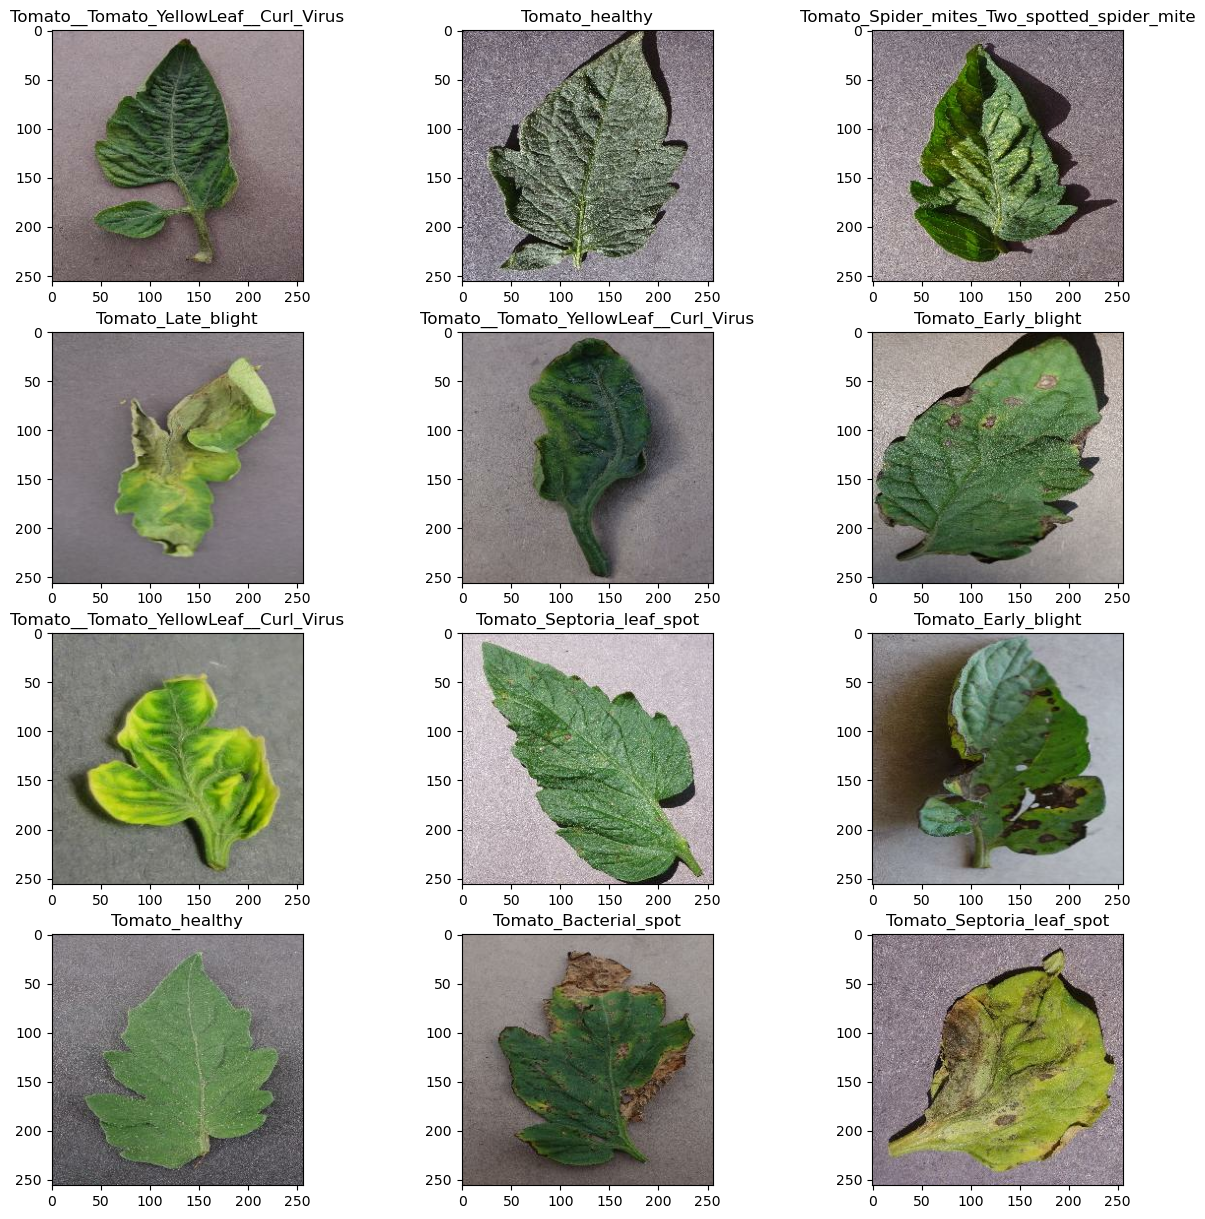

In [6]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in data.take(1):
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.title(classname[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        

# Training and testing validation

80%-->training

20%-->testing

# training size

In [7]:
train_size=len(data)*0.8
print(train_size)

400.8


In [8]:
train_data=data.take(400)
print(len(train_data))

400


# validation set

In [9]:
val_size=len(data)*0.1
print(val_size)

50.1


In [10]:
val_data=data.skip(400).take(50)
print(len(val_data))

50


# testing data

In [11]:
test_data=data.skip(450)
print(len(test_data))

51


# wrapping into one code

In [12]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    len_dataset=len(ds)#length of whole dataset-->size
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(len_dataset*train_split)#training size 80%
    validation_size=int(val_split*len_dataset)#validation size 10%
    
    train_ds=ds.take(train_size)#taking 80%for training
    val_ds=ds.skip(train_size).take(validation_size)# taking 10% for validation
    testing_ds=ds.skip(train_size).skip(validation_size)#taking 10% for testing
    
    return train_ds,val_ds,testing_ds

In [13]:
trainingdata,validationdata,testingdata=get_dataset_partitions(data)

In [14]:
print("traindata:",len(trainingdata))
print("validationdata:",len(validationdata))
print("testdata:",len(testingdata))

traindata: 400
validationdata: 50
testdata: 51


# caching and prefetching

In [15]:
#for training data
trainingdata=trainingdata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#for training data
validation=validationdata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#for training data
testingdata=testingdata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing image data

preprocessing pipeline

In [16]:
resize_rescale=tf.keras.Sequential([
    #resizing
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    #scaling by diving with 255
    layers.experimental.preprocessing.Rescaling(1/255.0)
])

# DataAugmentation

In [17]:
data_augmentation=tf.keras.Sequential([
    #flipping the image
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
    #rotating the image
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

# ModelBuilding

In [19]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
num_of_class=10
model=models.Sequential([
   
     resize_rescale,
     data_augmentation,
    
    #building layers
    #layer1:
    #param:filters,kernelsize,activation,
    
    #1]filters-->random num recommend to use pow of 2 and
    #2] kernel_size-->(height,width) give in odd,odd eg:(1,1)  (3,3)
    #3]activation layer-->basicallly we use relu
     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),#convolution layer
     layers.MaxPooling2D((2,2)),#ppoling layer
    #layer 2:
     layers.Conv2D(64,(3,3),activation='relu'),#convolution layer
     layers.MaxPooling2D((2,2)),#ppoling layer
    #layer 3:
     layers.Conv2D(64,(3,3),activation='relu'),#convolution layer
     layers.MaxPooling2D((2,2)),#ppoling layer
    #layer 4:
     layers.Conv2D(128,(3,3),activation='relu'),#convolution layer
     layers.MaxPooling2D((2,2)),#ppoling layer 
    #layer 5:
    layers.Conv2D(256,(3,3),activation='relu'),#convolution layer
    layers.MaxPooling2D((2,2)),#ppoling layer
    
 
    
    #flattening the layer
    layers.Flatten(),
    
    #hidden layer
    layers.Dense(256,activation='relu'),
    layers.Dense(num_of_class,activation='softmax')
])

# BUILDING MODEL

In [20]:
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
         metrics=['accuracy'])

In [26]:
history=model.fit(
trainingdata,
epochs=2,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_data
)

Epoch 1/2
400/400 [==============================] - 966s 2s/step - loss: 0.0374 - accuracy: 0.9871 - val_loss: 0.3204 - val_accuracy: 0.9106
Epoch 2/2
400/400 [==============================] - 1239s 3s/step - loss: 0.0611 - accuracy: 0.9795 - val_loss: 0.2715 - val_accuracy: 0.9225


# Evaluating the model using test data

In [28]:
scores=model.evaluate(testingdata)

51/51 [==============================] - 110s 1s/step - loss: 0.2964 - accuracy: 0.9148


In [29]:
scores  #loss,acccuracy

[0.2963724732398987, 0.9148284196853638]

In [31]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 400}

# To get keys of history of model

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.987109363079071, 0.9795312285423279]

In [34]:
history_accuracy=history.history['accuracy']
history_val_accuracy=history.history['val_accuracy']
history_loss=history.history['loss']
history_val_loss=history.history['val_loss']

In [35]:
print("accuracy",history_accuracy)
print()
print("val_accurcay",history_val_accuracy)
print()
print("history_loss",history_loss)
print()
print("history_val_loss",history_val_loss)

accuracy [0.987109363079071, 0.9795312285423279]

val_accurcay [0.9106249809265137, 0.9225000143051147]

history_loss [0.03744381293654442, 0.0611446350812912]

history_val_loss [0.32042574882507324, 0.2715480327606201]


# Predicting our model test data

In [40]:
import numpy as np

first image to predict
actual_label Tomato__Target_Spot
model prediction
1/1 [==============================] - 4s 4s/step
predicted label Tomato__Target_Spot


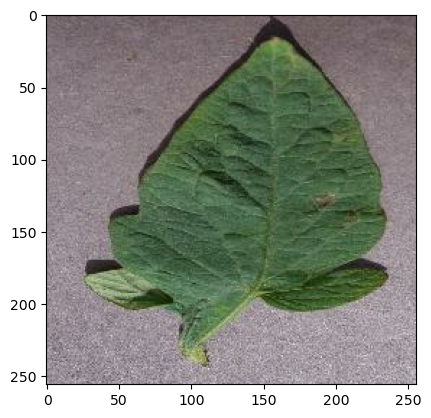

In [41]:
for images_batch,label_batch in test_data.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("actual_label",classname[first_label])
    
    print('model prediction')
    batch_prediction=model.predict(images_batch)
    print('predicted label',classname[np.argmax(batch_prediction[0])])

In [44]:
def predict(model,img):
    #first-->converting image to array
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    #expand_dims  :param==>input,axis,name(optional)
    #to insert addition dimension in tensor
    #how it performs:
    '''[[1,2,3]
    [4,5,6]] 2x3 mat
    aplying: expand_dims(mat,0)     expand_dims(mat,1)
        
    o/p:                            op:  [[[1,2,3]],[[4,5,6]]] shape==>2,1,3
           [[[1,2,3],[4,5,6]]]
        shape==>1,2,3'''
        
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=classname[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 94ms/step


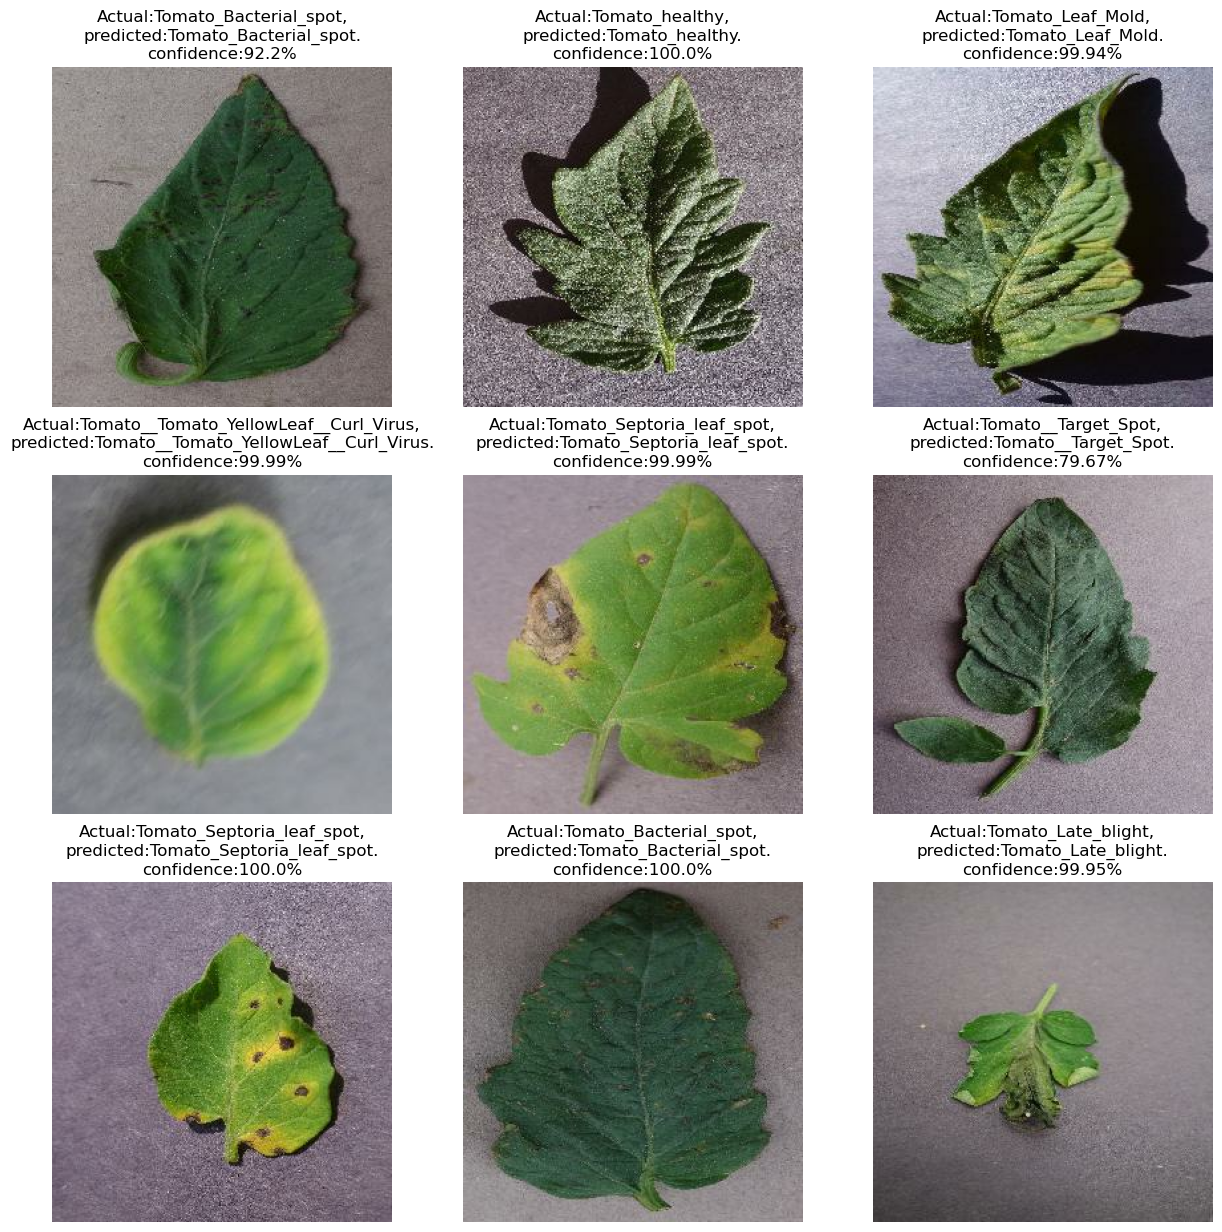

In [46]:
plt.figure(figsize=(15,15))
for images,labels in testingdata.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i])
        actual_class=classname[labels[i]]
        plt.title(f"Actual:{actual_class},\npredicted:{predicted_class}.\nconfidence:{confidence}%")
        plt.axis('off')

# Saving the model

In [48]:
model.save('tomato.h5')